In [166]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *
from xbbg import blp
import sys
sys.path.append(r'\\10.5.20.31\交易部\Blair\backTestTool')
sys.path.append(r'\\10.5.20.31\交易部\FX trading Strategy souce code\Wilson\程式碼')
sys.path.append(r'C:\Users\Blair Lin\quantTrade_2024')
import portStats

import sys
from contextlib import contextmanager
import io
import os

# Add this at the beginning of your code, after the imports
strgyName = '1104'
traderName = 'Blair'

devCcy =  ['EUR', 'JPY', 'GBP', 'CHF', 'AUD', 'CAD', 'NZD', 'SEK']
revL = ['NZD', 'EUR', 'AUD', 'GBP']
basket = ['EUR', 'JPY', 'GBP', 'CHF', 'AUD', 'CAD', 'NZD', 'SEK', 'INR', 'IDR', 'ZAR', 'CNH', 'SGD']

In [167]:
from datetime import datetime
today = datetime.now()+pd.Timedelta(days=0)
today_str = today.strftime('%Y-%m-%d')
startDate = today-pd.Timedelta(days=600)

# startDate = startDate.strftime('%Y-%m-%d')
startDate = '2012-01-01'
endDate = today_str

dr = pd.date_range(
    start=pd.to_datetime(startDate),
    end=pd.to_datetime(endDate),
    freq=BDay()
) 


df = pd.DataFrame(index=dr)

df['US2Y'] = blp.bdh(tickers='USGG2YR Index', flds = ["PX_LAST"], start_date=startDate, end_date=endDate)
df['US10Y'] = blp.bdh(tickers='USGG10YR Index', flds = ["PX_LAST"], start_date=startDate, end_date=endDate)
df['us2y10y'] = df['US2Y'] - df['US10Y']

df['VIX'] = blp.bdh(tickers='VIX Index', flds = ["PX_LAST"], start_date=startDate, end_date=endDate)

df['emRet'] = blp.bdh(tickers='M1EF Index', flds = ["PX_LAST"], start_date=startDate, end_date=endDate) * -1
df['rr'] = blp.bdh(tickers='USDJPY25R1M BGN Curncy', flds = ["PX_LAST"], start_date=startDate, end_date=endDate) * -1
df['fxVol'] = blp.bdh(tickers='CVIX Index', flds = ["PX_LAST"], start_date=startDate, end_date=endDate)


df = df.iloc[1:, ]
df.drop(columns=['US2Y', 'US10Y'], inplace=True)
df.fillna(method='ffill', inplace=True)
df = df.shift(1)


In [168]:
# df.to_csv('macroRiskComponent_shifted.csv')

In [169]:
df

,us2y10y,VIX,emRet,rr,fxVol
2012-01-03,NaN,NaN,NaN,NaN,NaN
2012-01-04,-1.6924,22.97,-365.74,-0.1575,12.1172
2012-01-05,-1.7179,22.22,-364.82,-0.1675,11.9622
2012-01-06,-1.7353,21.48,-362.84,-0.1500,12.0672
2012-01-09,-1.7019,20.63,-360.76,-0.1750,11.7851
...,...,...,...,...,...
2025-03-17,-0.2951,21.77,-599.46,1.3750,8.1300
2025-03-18,-0.2544,20.51,-605.81,1.3325,8.0200
2025-03-19,-0.2433,21.70,-613.48,1.2250,7.8300
2025-03-20,-0.2705,19.90,-612.52,1.2175,7.9800


In [170]:
tickerMap = dict(zip(df.columns, ['USGG2YR Index', 'VIX Index', 'M1EF Index', 'USDJPY25R1M BGN Curncy', 'CVIX Index']))
tickerMap


{'us2y10y': 'USGG2YR Index',
 'VIX': 'VIX Index',
 'emRet': 'M1EF Index',
 'rr': 'USDJPY25R1M BGN Curncy',
 'fxVol': 'CVIX Index'}

In [171]:
def calculate_vix_dxy_correlation(start_date, end_date, asset, rolling_window=60):
    """
    Calculates the historical rolling correlation between VIX and DXY
    
    Parameters:
    start_date (str): Start date in 'YYYY-MM-DD' format
    end_date (str): End date in 'YYYY-MM-DD' format
    rolling_window (int): Window size for rolling correlation
    
    Returns:
    pd.DataFrame: DataFrame with VIX, DXY, and their rolling correlation
    """
    # Create date range
    dr_corr = pd.date_range(
        start=pd.to_datetime(start_date),
        end=pd.to_datetime(end_date),
        freq=BDay()
    )
    
    # Get VIX and DXY data for the full period
    vix_data = blp.bdh(tickers=asset, flds=["PX_LAST"], 
                       start_date=start_date, end_date=end_date)
    if asset == 'USGG2YR Index':
        vix_data1 = blp.bdh(tickers='USGG2YR Index', flds=["PX_LAST"], 
                        start_date=start_date, end_date=end_date)
        vix_data2 = blp.bdh(tickers='USGG10YR Index', flds=["PX_LAST"], 
                        start_date=start_date, end_date=end_date)
        vix_data = vix_data1['USGG2YR Index']-vix_data2['USGG10YR Index']
        # print(vix_data)
    
    dxy_data = blp.bdh(tickers='DXY Index', flds=["PX_LAST"], 
                       start_date=start_date, end_date=end_date)
    
    # Combine into a single DataFrame and handle any missing values
    corr_df = pd.DataFrame(index=dr_corr)
    corr_df['VIX'] = vix_data
    corr_df['DXY'] = dxy_data
    corr_df = corr_df.fillna(method='ffill')
    
    # Calculate daily returns
    corr_df['VIX_ret'] = corr_df['VIX'].pct_change()
    corr_df['DXY_ret'] = corr_df['DXY'].pct_change()
    
    # Calculate rolling correlation
    corr_df['rolling_corr'] = corr_df['VIX_ret'].rolling(window=rolling_window).corr(corr_df['DXY_ret'])
    
    # Add a few useful columns
    corr_df['rolling_corr_mean'] = corr_df['rolling_corr'].rolling(window=252).mean()
    corr_df['rolling_corr_std'] = corr_df['rolling_corr'].rolling(window=252).std()
    corr_df['corr_z_score'] = (corr_df['rolling_corr'] - corr_df['rolling_corr_mean']) / corr_df['rolling_corr_std']
    
    return corr_df

In [172]:
tickerMap

{'us2y10y': 'USGG2YR Index',
 'VIX': 'VIX Index',
 'emRet': 'M1EF Index',
 'rr': 'USDJPY25R1M BGN Curncy',
 'fxVol': 'CVIX Index'}

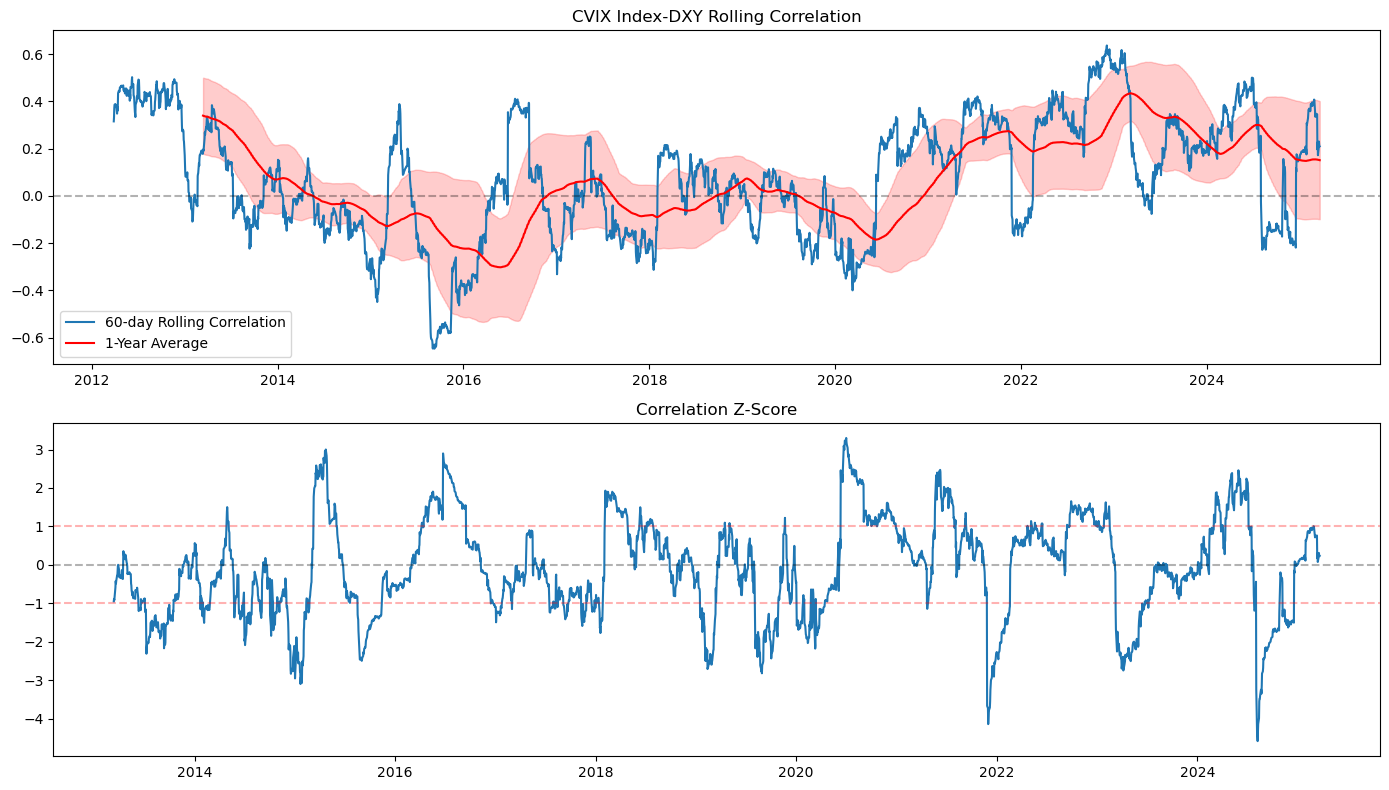

In [173]:
corr_df = calculate_vix_dxy_correlation(startDate, endDate, asset=tickerMap['VIX'], rolling_window=60)
# corr_df = calculate_vix_dxy_correlation(startDate, endDate, asset=mri, rolling_window=60)
# corr_df = corr_df[corr_df.index.year == 2025]
corr_df.to_csv(f'{today_str}_VIX_DXY_Correlation.csv')

# Create a plot to visualize the correlation over time
plt.figure(figsize=(14, 8))
plt.subplot(211)
plt.plot(corr_df.index, corr_df['rolling_corr'], label='60-day Rolling Correlation')
plt.plot(corr_df.index, corr_df['rolling_corr_mean'], label='1-Year Average', color='red')
plt.fill_between(corr_df.index, 
                corr_df['rolling_corr_mean'] - corr_df['rolling_corr_std'], 
                corr_df['rolling_corr_mean'] + corr_df['rolling_corr_std'], 
                alpha=0.2, color='red')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.legend()
plt.title(f'{tickerMap['fxVol']}-DXY Rolling Correlation')

plt.subplot(212)
plt.plot(corr_df.index, corr_df['corr_z_score'])
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.axhline(y=1, color='red', linestyle='--', alpha=0.3)
plt.axhline(y=-1, color='red', linestyle='--', alpha=0.3)
plt.title('Correlation Z-Score')
plt.tight_layout()
# plt.savefig(f'{today_str}_VIX_DXY_Correlation.png')
# plt.close()

In [174]:
corr_df.head(5)

,VIX,DXY,VIX_ret,DXY_ret,rolling_corr,rolling_corr_mean,rolling_corr_std,corr_z_score
2012-01-02,NaN,80.280,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-03,22.97,79.611,NaN,-0.008333,NaN,NaN,NaN,NaN
2012-01-04,22.22,80.129,-0.032651,0.006507,NaN,NaN,NaN,NaN
2012-01-05,21.48,80.936,-0.033303,0.010071,NaN,NaN,NaN,NaN
2012-01-06,20.63,81.254,-0.039572,0.003929,NaN,NaN,NaN,NaN


In [175]:
### get original signal
def rolling_percentile(data, window=150, min_periods=None):
    """
    calculate rolling percnetile over specific window
    """
    if min_periods is None:
        min_periods = window

    def percentile_rank(window):
        current = window.iloc[-1]
        # print(window, current)
        # print((window <= current).mean())
        return pd.Series([(window <= current).mean() * 100])

    return data.rolling(window=window, min_periods=min_periods).apply(percentile_rank)

def updateW(col):
    count = 0
    pos = 0


    for x in col:
        raw = mri.iloc[count]
        ma = mriMA.iloc[count]

        if (raw > ma):
            if pos == 0:
                # print(f'目前 MRI 為: {raw}，開倉做空風險貨幣')
                pos = -1
            elif pos == 1:
                #print(f'目前 MRI 為: {raw}，關閉做多的風險貨幣')
                pos = 0
        elif (raw < ma) & (pos != 0):
            # if pos == 0:
            #     print(f'目前 MRI 為: {raw}，承平時刻，做多風險貨幣')
            #     pos = 1
            if pos == -1:
                #print(f'目前 MRI 為: {raw}，關閉做空的風險貨幣')
                pos = 0  
        elif (raw < ma) & (pos == 0):
            pass
        col[count] = pos
        count += 1

    return col

roll_Pctl = pd.DataFrame(index=dr, columns=df.columns)
for asset in roll_Pctl.columns:
    roll_Pctl[asset] = rolling_percentile(df[asset])

roll_Pctl['simple_avg'] = roll_Pctl.mean(axis=1)

mri = roll_Pctl['simple_avg'].copy()
mriMA = mri.rolling(20).mean()

signalDf = pd.DataFrame(index=dr, columns=basket)
signalDf = signalDf.apply(updateW, axis=0)


In [176]:
def updateW_with_corr_regime(col):
    count = 0
    pos = 0
    
    for x in col:
        raw = mri.iloc[count]
        ma = mriMA.iloc[count]
        
        # Get the date for this row
        current_date = dr[count]
        
        # Get correlation information for this date if available
        try:
            current_corr = corr_df.loc[current_date, 'rolling_corr']
            current_z = corr_df.loc[current_date, 'corr_z_score']
            regime_valid = current_corr > 0.2  # Adjust threshold as needed
        except:
            # Default to True if we don't have correlation data
            regime_valid = True
            current_corr = 0
            current_z = 0
        
        if (raw > ma):
            if pos == 0 and regime_valid:
                # Only take new positions if correlation regime is valid
                pos = -1
            elif pos == 1:
                pos = 0
        elif (raw < ma) & (pos != 0):
            if pos == -1:
                pos = 0  
        elif (raw < ma) & (pos == 0):
            pass
            
        # Scale position by correlation strength if needed
        # Uncomment to enable position scaling
        # if pos != 0:
        #     scale_factor = min(1.0, max(0.25, abs(current_corr)))
        #     pos = pos * scale_factor
            
        col[count] = pos
        count += 1

    return col

In [177]:
signalDf = signalDf.apply(updateW_with_corr_regime, axis=0)

for ccy in signalDf:
    if ccy not in revL:
        signalDf[ccy] = -1*signalDf[ccy] # 將訊號轉為市場慣例 (USDJPY +1 為 long USDJPY, EURUSD +1 為 long EURUSD)
signalDf = signalDf * (1/len(basket)) 
weight_size = 4
signalDf = signalDf * weight_size

In [178]:
# ## get market data
# from xbbg import blp

# basket = signalDf.columns
# ohlcTickers = [ f'{i} BGN Curncy' for i in basket]
# ohlc = pd.DataFrame(columns=basket)

# instruments = ohlcTickers

# ohlcD = dict.fromkeys(basket)
# for k in ohlcD.keys():
#     ohlcD[k] = pd.DataFrame(columns=['PX_OPEN', 'PX_LAST', 'PX_LOW', 'PX_HIGH'])

# count = 0
# for i in instruments:
#     for fld in ['PX_OPEN', 'PX_LAST', 'PX_LOW', 'PX_HIGH']:
#         tmpS = blp.bdh(tickers=instruments[count], flds=fld, start_date=startDate, end_date=endDate).shift(1)
#         ohlcD[basket[count]][fld] = tmpS
#         tmpIdx = tmpS.index
#         ohlcD[basket[count]].index = pd.DatetimeIndex(ohlcD[basket[count]].index)
#         if fld == 'PX_HIGH':
#             ohlcD[basket[count]].index = tmpIdx
#     count += 1

# ohlc.index = pd.DatetimeIndex(ohlc.index)
# np.save('ohlc_BGN_EM.npy', ohlcD)

In [179]:
# backtest
ohlcD = np.load('ohlc_BGN_EM.npy',allow_pickle='TRUE').item()
spot = pd.DataFrame(index=dr, columns=basket)
for col in spot.columns:
    spot[col] = ohlcD[col]['PX_LAST']
spot.tail()

,EUR,JPY,GBP,CHF,AUD,CAD,NZD,SEK,INR,IDR,ZAR,CNH,SGD
2025-03-17,1.0879,148.64,1.2935,0.8851,0.6324,1.4366,0.5748,10.1391,87.0075,16350.0,18.1969,7.2379,1.3342
2025-03-18,1.0922,149.21,1.2992,0.8809,0.6384,1.4288,0.5820,10.0879,86.8000,16406.0,18.0857,7.2271,1.3302
2025-03-19,1.0945,149.27,1.3001,0.8767,0.6361,1.4298,0.5820,10.0426,86.5663,16428.0,18.1444,7.2277,1.3306
2025-03-20,1.0903,148.69,1.3003,0.8778,0.6357,1.4326,0.5815,10.1034,86.4388,16531.0,18.1222,7.2309,1.3306
2025-03-21,1.0851,148.78,1.2967,0.8819,0.6303,1.4325,0.5758,10.1308,86.3725,16485.0,18.1594,7.2522,1.3348


<Axes: >

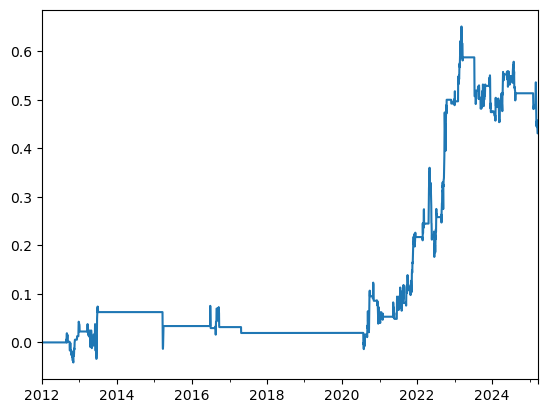

In [180]:
# 取的每日損益
btSpot = spot.copy()
btSpot.index = pd.DatetimeIndex(btSpot.index)
btSpot = btSpot.reindex(dr).ffill()

global btDailyRet 
btDailyRet = (btSpot-btSpot.shift(1))/btSpot

portDailyChange = btDailyRet * signalDf.shift(1)
portDailyChange['port'] = portDailyChange.sum(axis=1)
portDailyChange['port'].cumsum().plot()

In [181]:
def getStats(totalCount, dailyS, cumS):
    s = pd.Series()
    # s['Mean'] = (1 + cumS[-1]) ** (250 / totalCount) - 1
    # s['Mean'] = (1+dailyS[1:].sum()/totalCount) * 250 - 1

    if totalCount >= 252:
        s['Mean'] = (dailyS[0:].sum()) / totalCount * 252
        s['Std'] = (dailyS[0:].std()) * np.sqrt(252)
    else:
        s['Mean'] = (dailyS[0:].sum()) / totalCount * totalCount
        s['Std'] = (dailyS[0:].std()) * np.sqrt(totalCount)

    s['Sharpe'] = s['Mean'] / s['Std']
    # mddForPlot = maxDDVer3(cumS)[0]
    # periodHigh = maxDDVer3(cumS)[1]
    # s['MDD'] = np.min(mddForPlot)
                                                                                                 
    return s

In [182]:
getStats(totalCount=portDailyChange.shape[0], dailyS=portDailyChange['port'], cumS=portDailyChange['port'].cumsum())

Mean      0.031476
Std       0.095559
Sharpe    0.329392
dtype: float64

In [183]:
tmp = portDailyChange[portDailyChange.index.year <= 2023]
getStats(totalCount=tmp.shape[0], dailyS=tmp['port'], cumS=tmp['port'].cumsum())

Mean      0.038209
Std       0.093623
Sharpe    0.408118
dtype: float64